
Ce code nous a permis de construire la base d'images et de textes de test à partir des images prétraitées avec la fonction construite précédemment pour l'OCR.

In [4]:
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os
import math
from typing import Tuple, Union
from PIL import Image
import re
from deskew import determine_skew
import itertools

In [1]:
#Retourne l'OCR
def ocr(img):
    img = img.astype(np.uint8)
    processed_text = pytesseract.image_to_string(img)
    return processed_text

#FONCTION QUI RETOURNE L'IMAGE EN GRAYSCALE
def conv_gray(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    return gray

def adjust_histogram(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adjusted_image = cv2.equalizeHist(gray_image)
    
    # Afficher l'image ajustée
    #cv2.imshow("Image ajustée", adjusted_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    return adjusted_image

def resize_image(image, scale_factor=1.2):
    # Obtient les dimensions de l'image d'origine
    height, width = image.shape[:2]

    # Calcule les nouvelles dimensions en fonction du facteur d'échelle
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)

    # Redimensionne l'image en utilisant la nouvelle taille
    resized_image = cv2.resize(image, (new_width, new_height))

    return resized_image

#ROTATION/DESKEWING
#https://pypi.org/project/deskew/
def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

def deskewing(image):
    #niv de gris
    if len(image.shape) == 3:  # Vérification si l'image n'est pas déjà en niveaux de gris
      gray = gray = conv_gray(image)
    else:
          gray = image
    #gray = conv_gray(image)
    angle = determine_skew(gray)
    rotated = rotate(image, angle, (255, 255, 255))
    return rotated

# Appliquer une transformation racine carrée pour ajuster la luminosité
def adjust_brightness(image):
    adjusted_image = np.sqrt(image)
    adjusted_image = (255 * (adjusted_image / np.max(adjusted_image))).astype(np.uint8)
    return adjusted_image

# Appliquer une binarisation adaptative à l'image en niveaux de gris
def apply_adaptive_binarization(image, block_size=11, constant=2):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, block_size, constant)
    return binary_image


# Ajuster le contraste de l'image après binarisation
def adjust_contrast_after_binarization(image, alpha=1.5, beta=0.5):
    contrast_adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return contrast_adjusted_image


# Appliquer une transformation morphologique d'érosion
def improve_letter_readability(image, kernel_size=(3, 3), iterations=1):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    kernel = np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(gray_image, kernel, iterations=iterations)
    return eroded_image

# Inverser les couleurs de l'image en utilisant le complément de 255 (blanc - couleur = couleur inversée)
def invert_colors(image):
    inverted_image = 255 - image
    return inverted_image

# Fonction de binarisation

def binarisation(image):
    if len(image.shape) == 3:  # Vérification si l'image n'est pas déjà en niveaux de gris
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary

def adjust_contrast(image, alpha=1.5, beta=0.5):
    # Ajuster le contraste de l'image après binarisation
    contrast_adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return contrast_adjusted_image


################TEXT#################

#supprimer les lignes vides et les lignes non pertinentes.
def preprocess_text(text):
    non_empty_lines = [line.strip() for line in text.split('\n') if line.strip() != '']
    filtered_lines = []
    for line in non_empty_lines:
        if len(line) <= 1 or re.match(r'^[a-zA-Z]+( [a-zA-Z]+)*$', line):
            continue
        filtered_lines.append(line)
    return '\n'.join(filtered_lines)

def count_lines(text):
    return len(text.split('\n'))

def find_text_with_most_lines(texts):
    lines_counts = [count_lines(text) for text in texts]
    max_lines = max(lines_counts)
    texts_with_max_lines = [text for text, count in zip(texts, lines_counts) if count == max_lines]
    if len(texts_with_max_lines) == 1:
        return texts_with_max_lines[0]
    else:
        max_chars = max(len(text) for text in texts_with_max_lines)
        return next(text for text in texts_with_max_lines if len(text) == max_chars)


#Applique un prétraitement pour supprimer les lignes vides et les lignes non pertinentes.
def preprocess_text(text):
        # Supprimer les lignes vides
    non_empty_lines = [line.strip() for line in text.split('\n') if line.strip() != '']
    
    # Supprimer les lignes contenant une seule lettre ou des suites de lettres séparées par des espaces
    filtered_lines = []
    for line in non_empty_lines:
        if len(line) <= 1 or re.match(r'^[a-zA-Z]+( [a-zA-Z]+)*$', line):
            continue
        filtered_lines.append(line)
    
    return '\n'.join(filtered_lines)

CONTRUCTION DATASET POUR FAIRE LE TEST

In [16]:
def meilleur_text(fonctions_pretraitement, image_data):
    meilleur_resultat = 0
    meilleur_texte = ""

    # Convert the image data to a NumPy array
    image_array = np.frombuffer(image_data, dtype=np.uint8)
    image_array = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Assuming you're using OpenCV for image processing

    # OCR sans prétraitement
    ocr_result_sans_pretraitement = ocr(image_array)
    preprocessed_text_sans = preprocess_text(ocr_result_sans_pretraitement)
    num_lines_sans = count_lines(preprocessed_text_sans)
    meilleur_resultat = num_lines_sans
    meilleur_texte = preprocessed_text_sans

    # Appliquer vos fonctions de prétraitement
    image_array = deskewing(adjust_contrast(conv_gray(image_array)))

    # Générer toutes les combinaisons possibles de fonctions de prétraitement
    for n in range(1, len(fonctions_pretraitement) + 1):
        combinaisons = list(itertools.combinations(fonctions_pretraitement, n))

        # Appliquer les fonctions de prétraitement dans chaque combinaison
        for combinaison in combinaisons:
            donnees_pretraitees = image_array.copy()
            for fonction in combinaison:
                donnees_pretraitees = fonction(donnees_pretraitees)

            # OCR avec Tesseract
            ocr_result = ocr(donnees_pretraitees)

            # Prétraitement du texte OCR
            preprocessed_text = preprocess_text(ocr_result)

            # Comptage des lignes
            num_lines = count_lines(preprocessed_text)

            # Mettre à jour le meilleur texte en fonction du nombre de lignes
            if num_lines > meilleur_resultat:
                meilleur_resultat = num_lines
                meilleur_texte = preprocessed_text

    return meilleur_texte


def process_images(input_folder, output_folder, fonctions_pretraitement):
    for image_filename in os.listdir(input_folder):
        if image_filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(input_folder, image_filename)
            # Vérifier si un fichier texte existe déjà pour cette image
            resultat_filename = os.path.splitext(image_filename)[0] + ".txt"
            resultat_path = os.path.join(output_folder, resultat_filename)
            if os.path.exists(resultat_path):
                #print(f"Le fichier texte pour l'image {image_filename} existe déjà. Passant à l'image suivante.")
                continue
            
            try:
                with open(image_path, 'rb') as image_file:
                    image_data = image_file.read()

                meilleur_resultat = meilleur_text(fonctions_pretraitement, image_data)
                print(meilleur_resultat)

                # Créer un fichier pour stocker le résultat
                with open(resultat_path, 'w') as resultat_file:
                    resultat_file.write(meilleur_resultat)
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {image_filename}: {str(e)}")
                continue

    print("Traitement terminé.")

In [36]:
# Chemins des dossiers d'entrée et de sortie
dossier_images = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2"
dossier_resultats = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-preprocess"

# Liste des fonctions de prétraitement
fonctions_pretraitement = [resize_image, invert_colors, improve_letter_readability, adjust_brightness] 

# Appel de la fonction pour traiter les images
process_images(dossier_images, dossier_resultats, fonctions_pretraitement)

@ flocons de chocolat noir
INGREDIENTS Masse de cacao - Sucr
‘€Ca0 en poudre - Emulsifiant : Lécithine de
‘ja - Extrait de vanille. Chocolat noir contien
Cacao 70% minimum. Pour les allergénes, vc
les ingrédients indiqués en gras. Ne convient
; Pas aux personnes allergiques aux arachides,
aux fruits a coque, au lait et au bié et aux
; Personnes souffrant de la maladie Coeliaque er
raison des méthodes de fabrication.
SUISSON Dans une casserole, battre 40 g
@G cuillares & dessert bombées) de flocons de
chocolat et 50 ml de lait demi-écrémé chaud a
feu doux. Ajouter 150 mi de lait demi-écrémé
¢haud tout en continuant a battre le mélange a
feu doux jusqu'a ce qu'il frémisse. Ajouter gu
Sucre et/ou de la créme selon votre got. Servir
immédiatement. CONSERVATION A consomie
de préférence avant le : voir au dos de
'emballage. A conserver de référence dans un
endroit frais et sec, a I'abri de la lumiare.
Une fois ouvert, consommer dans les 3 mois.
Uur ingreatents: Cranberries (16%) (Sugar, Cran

CONSTRUCTION DATASET DE l'OCR

In [35]:
def ocr_images_in_directory(input_folder, output_folder):
    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste des extensions d'images prises en charge
    supported_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Parcours des fichiers dans le dossier d'entrée
    for filename in os.listdir(input_folder):
        file_extension = os.path.splitext(filename)[1].lower()
        
        # Vérifier si l'extension est prise en charge
        if file_extension in supported_extensions:
            image_path = os.path.join(input_folder, filename)
            
            # Charger l'image
            image = Image.open(image_path)
            
            # Appliquer OCR avec Tesseract
            ocr_result = pytesseract.image_to_string(image, lang='eng')
            
            # Créer le chemin de sortie pour le fichier OCR
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.txt')
            
            # Écrire le résultat OCR dans le fichier de sortie
            with open(output_path, 'w', encoding='utf-8') as output_file:
                output_file.write(ocr_result)
            
            print(f"OCR effectué pour {filename} et enregistré dans {output_path}")

# Chemins vers le dossier d'entrée contenant les images et le dossier de sortie pour les fichiers OCR
input_folder_path = r'C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2'
output_folder_path = r'C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr'

# Appeler la fonction pour effectuer l'OCR sur les images dans le dossier d'entrée
ocr_images_in_directory(input_folder_path, output_folder_path)


OCR effectué pour -images.openfoodfacts.org-images-products-00054072-ingredients_fr.14.400.jpg et enregistré dans C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr\-images.openfoodfacts.org-images-products-00054072-ingredients_fr.14.400.txt
OCR effectué pour -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg et enregistré dans C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr\-images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.txt
OCR effectué pour -images.openfoodfacts.org-images-products-00168953-ingredients_en.11.400.jpg et enregistré dans C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr\-images.openfoodfacts.org-images-products-00168953-ingredients_en.11.400.txt
OCR effectué pour -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg et enregistré dans C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr\-images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.txt
OCR effectué pour -images.openfoodfacts.or

COMPARAISON ENTRE LES FICHIERS

Le fichier -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg.txt n'existe pas dans le deuxième dossier.
Le fichier -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg.txt n'existe pas dans le deuxième dossier.


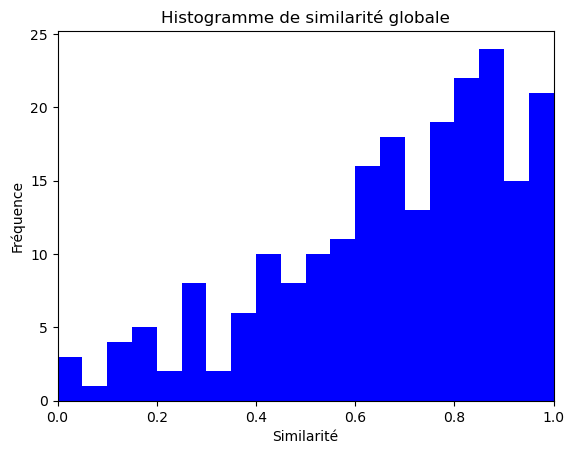

Nombre de fichiers avec une similarité >= 0.5 : 169


In [2]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour calculer la similarité de Jaccard entre deux ensembles
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Chemins des dossiers contenant les fichiers
dossier1 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure"
dossier2 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-preprocess"

similarites = []  # Liste pour stocker les similarités
nombre_similarites_elevees = 0  # Compteur pour les similarités élevées

# Parcourir les fichiers dans le premier dossier
for filename in os.listdir(dossier1):
    if filename.endswith(".txt"):
        chemin_fichier1 = os.path.join(dossier1, filename)
        chemin_fichier2 = os.path.join(dossier2, filename)

        # Vérifier si le fichier existe dans le deuxième dossier
        if os.path.exists(chemin_fichier2):
            # Lire le contenu des fichiers
            with open(chemin_fichier1, "r", encoding="utf-8") as file:
                contenu1 = file.read()
            with open(chemin_fichier2, "r", encoding="utf-8") as file:
                contenu2 = file.read()

            # Convertir le contenu en ensembles de mots
            mots1 = set(contenu1.split())
            mots2 = set(contenu2.split())

            # Calculer la similarité de Jaccard
            similarity = jaccard_similarity(mots1, mots2)

            # Ajouter la similarité à la liste
            similarites.append(similarity)

            # Vérifier la similarité élevée
            if similarity >= 0.5:
                nombre_similarites_elevees += 1

        else:
            print(f"Le fichier {filename} n'existe pas dans le deuxième dossier.")

# Dessiner le graphe de similarité global
plt.figure()
plt.hist(similarites, bins=20, color="blue")
plt.title("Histogramme de similarité globale")
plt.xlabel("Similarité")
plt.ylabel("Fréquence")
plt.xlim(0, 1)  # Limiter l'axe x entre 0 et 1
plt.show()

# Afficher le nombre de similarités élevées
print(f"Nombre de fichiers avec une similarité >= 0.5 : {nombre_similarites_elevees}")


Le fichier -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg.txt n'existe pas dans le deuxième dossier.
Le fichier -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg.txt n'existe pas dans le deuxième dossier.


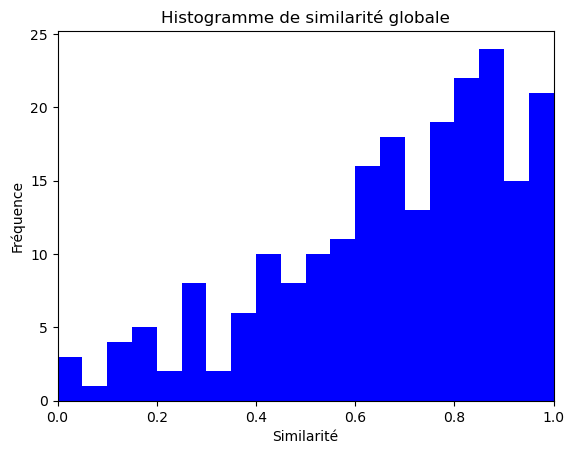

Nombre total de fichiers : 220
Nombre de fichiers avec une similarité >= 0.5 : 169
Pourcentage de fichiers avec une similarité >= 0.5 : 76.82%


In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour calculer la similarité de Jaccard entre deux ensembles
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Chemins des dossiers contenant les fichiers
dossier1 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure"
dossier2 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-preprocess"

similarites = []  # Liste pour stocker les similarités
nombre_similarites_elevees = 0  # Compteur pour les similarités élevées

# Parcourir les fichiers dans le premier dossier
total_fichiers = 0

for filename in os.listdir(dossier1):
    if filename.endswith(".txt"):
        total_fichiers += 1
        chemin_fichier1 = os.path.join(dossier1, filename)
        chemin_fichier2 = os.path.join(dossier2, filename)

        # Vérifier si le fichier existe dans le deuxième dossier
        if os.path.exists(chemin_fichier2):
            # Lire le contenu des fichiers
            with open(chemin_fichier1, "r", encoding="utf-8") as file:
                contenu1 = file.read()
            with open(chemin_fichier2, "r", encoding="utf-8") as file:
                contenu2 = file.read()

            # Convertir le contenu en ensembles de mots
            mots1 = set(contenu1.split())
            mots2 = set(contenu2.split())

            # Calculer la similarité de Jaccard
            similarity = jaccard_similarity(mots1, mots2)

            # Ajouter la similarité à la liste
            similarites.append(similarity)

            # Vérifier la similarité élevée
            if similarity >= 0.5:
                nombre_similarites_elevees += 1

        else:
            print(f"Le fichier {filename} n'existe pas dans le deuxième dossier.")

# Calculer le pourcentage de fichiers avec une similarité élevée
pourcentage_similarites_elevees = (nombre_similarites_elevees / total_fichiers) * 100 if total_fichiers > 0 else 0

# Dessiner le graphe de similarité global
plt.figure()
plt.hist(similarites, bins=20, color="blue")
plt.title("Histogramme de similarité globale")
plt.xlabel("Similarité")
plt.ylabel("Fréquence")
plt.xlim(0, 1)  # Limiter l'axe x entre 0 et 1
plt.show()

# Afficher les statistiques
print(f"Nombre total de fichiers : {total_fichiers}")
print(f"Nombre de fichiers avec une similarité >= 0.5 : {nombre_similarites_elevees}")
print(f"Pourcentage de fichiers avec une similarité >= 0.5 : {pourcentage_similarites_elevees:.2f}%")


Le fichier -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg.txt n'existe pas dans le deuxième dossier.
Le fichier -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg.txt n'existe pas dans le deuxième dossier.


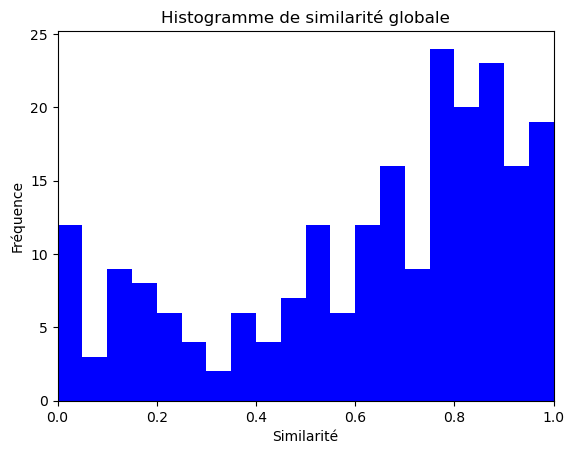

Nombre total de fichiers : 220
Nombre de fichiers avec une similarité >= 0.5 : 157
Pourcentage de fichiers avec une similarité >= 0.5 : 71.36%


In [2]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour calculer la similarité de Jaccard entre deux ensembles
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Chemins des dossiers contenant les fichiers
dossier1 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure"
dossier2 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr"

similarites = []  # Liste pour stocker les similarités
nombre_similarites_elevees = 0  # Compteur pour les similarités élevées

# Parcourir les fichiers dans le premier dossier
total_fichiers = 0

for filename in os.listdir(dossier1):
    if filename.endswith(".txt"):
        total_fichiers += 1
        chemin_fichier1 = os.path.join(dossier1, filename)
        chemin_fichier2 = os.path.join(dossier2, filename)

        # Vérifier si le fichier existe dans le deuxième dossier
        if os.path.exists(chemin_fichier2):
            # Lire le contenu des fichiers
            with open(chemin_fichier1, "r", encoding="utf-8") as file:
                contenu1 = file.read()
            with open(chemin_fichier2, "r", encoding="utf-8") as file:
                contenu2 = file.read()

            # Convertir le contenu en ensembles de mots
            mots1 = set(contenu1.split())
            mots2 = set(contenu2.split())

            # Calculer la similarité de Jaccard
            similarity = jaccard_similarity(mots1, mots2)

            # Ajouter la similarité à la liste
            similarites.append(similarity)

            # Vérifier la similarité élevée
            if similarity >= 0.5:
                nombre_similarites_elevees += 1

        else:
            print(f"Le fichier {filename} n'existe pas dans le deuxième dossier.")

# Calculer le pourcentage de fichiers avec une similarité élevée
pourcentage_similarites_elevees = (nombre_similarites_elevees / total_fichiers) * 100 if total_fichiers > 0 else 0

# Dessiner le graphe de similarité global
plt.figure()
plt.hist(similarites, bins=20, color="blue")
plt.title("Histogramme de similarité globale")
plt.xlabel("Similarité")
plt.ylabel("Fréquence")
plt.xlim(0, 1)  # Limiter l'axe x entre 0 et 1
plt.show()

# Afficher les statistiques
print(f"Nombre total de fichiers : {total_fichiers}")
print(f"Nombre de fichiers avec une similarité >= 0.5 : {nombre_similarites_elevees}")
print(f"Pourcentage de fichiers avec une similarité >= 0.5 : {pourcentage_similarites_elevees:.2f}%")


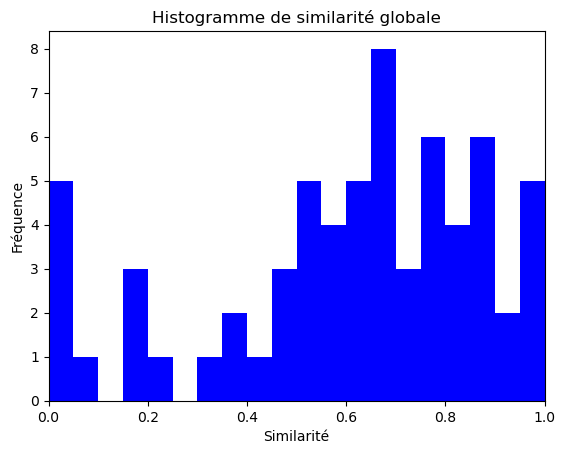

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour calculer la similarité de Jaccard entre deux ensembles
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Chemins des dossiers contenant les fichiers
dossier1 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure"
dossier2 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr"

similarites = []  # Liste pour stocker les similarités

# Parcourir les fichiers dans le premier dossier
for filename in os.listdir(dossier1):
    if filename.endswith(".txt"):
        chemin_fichier1 = os.path.join(dossier1, filename)
        chemin_fichier2 = os.path.join(dossier2, filename)

        # Vérifier si le fichier existe dans le deuxième dossier
        if os.path.exists(chemin_fichier2):
            # Lire le contenu des fichiers
            with open(chemin_fichier1, "r", encoding="utf-8") as file:
                contenu1 = file.read()
            with open(chemin_fichier2, "r", encoding="utf-8") as file:
                contenu2 = file.read()

            # Convertir le contenu en ensembles de mots
            mots1 = set(contenu1.split())
            mots2 = set(contenu2.split())

            # Calculer la similarité de Jaccard
            similarity = jaccard_similarity(mots1, mots2)

            # Ajouter la similarité à la liste
            similarites.append(similarity)

        else:
            print(f"Le fichier {filename} n'existe pas dans le deuxième dossier.")

# Dessiner le graphe de similarité global
plt.figure()
plt.hist(similarites, bins=20, color="blue")
plt.title("Histogramme de similarité globale")
plt.xlabel("Similarité")
plt.ylabel("Fréquence")
plt.xlim(0, 1)  # Limiter l'axe x entre 0 et 1
plt.show()


ZYADA

In [34]:
import os
import shutil

def extract_and_copy_images(text_folder, source_image_folder, destination_folder):
    for text_filename in os.listdir(text_folder):
        if text_filename.endswith('.txt'):
            image_name_from_text = os.path.splitext(text_filename)[0]  # Extract image name without extension
            
            image_filename = f"{image_name_from_text}"  # Image filename without path
            source_image_path = os.path.join(source_image_folder, image_filename)
            destination_image_path = os.path.join(destination_folder, image_filename)
            
            if os.path.exists(source_image_path):
                shutil.copy(source_image_path, destination_image_path)
                print(f"Image {image_filename} copied to {destination_image_path}")
            else:
                print(f"Image {image_filename} does not exist in the source folder.")

# Specify the paths for your folders
text_folder_path = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\try\resultats_texteAZURE"
source_image_folder_path = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\try"
destination_folder_path = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2"

extract_and_copy_images(text_folder_path, source_image_folder_path, destination_folder_path)


Image -images.openfoodfacts.org-images-products-00054072-ingredients_fr.14.400.jpg copied to C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2\-images.openfoodfacts.org-images-products-00054072-ingredients_fr.14.400.jpg
Image -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg copied to C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2\-images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.jpg
Image -images.openfoodfacts.org-images-products-00168953-ingredients_en.11.400.jpg copied to C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2\-images.openfoodfacts.org-images-products-00168953-ingredients_en.11.400.jpg
Image -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg copied to C:\Users\boss\Desktop\STAGE\CODE\TEST\img\CHOIX_POUR_TEST\P2\-images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.jpg
Image -images.openfoodfacts.org-images-products-00210461-ingredients_fr.9.400.

In [50]:
import os

def rename_files_in_directory(input_folder):
    # Parcours des fichiers dans le dossier
    for filename in os.listdir(input_folder):
        if filename.endswith('.txt'):
            if "-images.openfoodfacts.org-images-products-" in filename and filename.endswith('.jpg.txt') or "products-" in filename and filename.endswith('.jpg.txt'):
                new_filename = filename.replace('.jpg.txt', '.txt')  # Remplacer l'extension ".jpg.txt" par ".txt"
                
                original_path = os.path.join(input_folder, filename)
                new_path = os.path.join(input_folder, new_filename)
                
                # Vérifier si le nouveau nom existe déjà
                if not os.path.exists(new_path):
                    os.rename(original_path, new_path)
                    print(f"Fichier renommé de {filename} à {new_filename}")
                else:
                    print(f"Le fichier {new_filename} existe déjà. Conserver la version précédente.")

# Chemin vers le dossier contenant les fichiers texte
input_folder_path = r'C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure'

# Appeler la fonction pour renommer les fichiers dans le dossier
rename_files_in_directory(input_folder_path)


Le fichier -images.openfoodfacts.org-images-products-00148498-ingredients_en.8.400.txt existe déjà. Conserver la version précédente.
Le fichier -images.openfoodfacts.org-images-products-00180245-ingredients_en.13.400.txt existe déjà. Conserver la version précédente.
Fichier renommé de products-000-002-753-3048-ingredients_en.11.400.jpg.txt à products-000-002-753-3048-ingredients_en.11.400.txt
Fichier renommé de products-000-980-080-1107-ingredients_en.7.400.jpg.txt à products-000-980-080-1107-ingredients_en.7.400.txt
Fichier renommé de products-001-085-299-7489-ingredients_en.8.400.jpg.txt à products-001-085-299-7489-ingredients_en.8.400.txt
Fichier renommé de products-001-111-000-1207-ingredients_en.6.400.jpg.txt à products-001-111-000-1207-ingredients_en.6.400.txt
Fichier renommé de products-001-111-000-1986-ingredients_en.8.400.jpg.txt à products-001-111-000-1986-ingredients_en.8.400.txt
Fichier renommé de products-001-200-013-0274-ingredients_en.8.400.jpg.txt à products-001-200-013

DIFFERENTES METRIQUE

In [7]:
import os
from nltk.metrics import jaccard_distance
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(set1, set2):
    return 1 - jaccard_distance(set1, set2)

def sequence_similarity(str1, str2):
    matcher = SequenceMatcher(None, str1, str2)
    return matcher.ratio()

def tfidf_similarity(text1, text2):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

dossier1 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-azure"
dossier2 = r"C:\Users\boss\Desktop\STAGE\CODE\TEST\sortie-ocr"

similarites_jaccard = []
similarites_sequence = []
similarites_tfidf = []

for filename in os.listdir(dossier1):
    if filename.endswith(".txt"):
        chemin_fichier1 = os.path.join(dossier1, filename)
        chemin_fichier2 = os.path.join(dossier2, filename)

        if os.path.exists(chemin_fichier2):
            with open(chemin_fichier1, "r", encoding="utf-8") as file:
                contenu1 = file.read()
            with open(chemin_fichier2, "r", encoding="utf-8") as file:
                contenu2 = file.read()

            jaccard_sim = jaccard_similarity(set(contenu1.split()), set(contenu2.split()))
            sequence_sim = sequence_similarity(contenu1, contenu2)
            tfidf_sim = tfidf_similarity(contenu1, contenu2)

            similarites_jaccard.append(jaccard_sim)
            similarites_sequence.append(sequence_sim)
            similarites_tfidf.append(tfidf_sim)

            if jaccard_sim >= 0.5 or sequence_sim >= 0.5 or tfidf_sim >= 0.5:
                print(f"Similarité élevée dans le fichier {filename}")

        else:
            print(f"Le fichier {filename} n'existe pas dans le deuxième dossier.")

print("Moyenne des similarités (Jaccard) :", sum(similarites_jaccard) / len(similarites_jaccard))
print("Moyenne des similarités (Sequence) :", sum(similarites_sequence) / len(similarites_sequence))
print("Moyenne des similarités (TF-IDF) :", sum(similarites_tfidf) / len(similarites_tfidf))


Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-00000017-ingredients_fr.20.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-00000570-ingredients_en.13.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-000015-ingredients_fr.32.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-000020-ingredients_fr.30.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-000030-ingredients_fr.13.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-000031-ingredients_fr.8.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-000050-ingredients_fr.17.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-00012935-ingredients_en.11.400.txt
Similarité élevée dans le fichier -images.openfoodfacts.org-images-products-00013000-ingredients_fr.8.400.txt
Similarité él